In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

df = pd.read_csv('./results/all_results.csv', index_col=0)
df.sort_values(by='ratio', inplace=True)
df.drop_duplicates(keep='first', inplace=True)

n_iter: 10000, hard_constrained: True


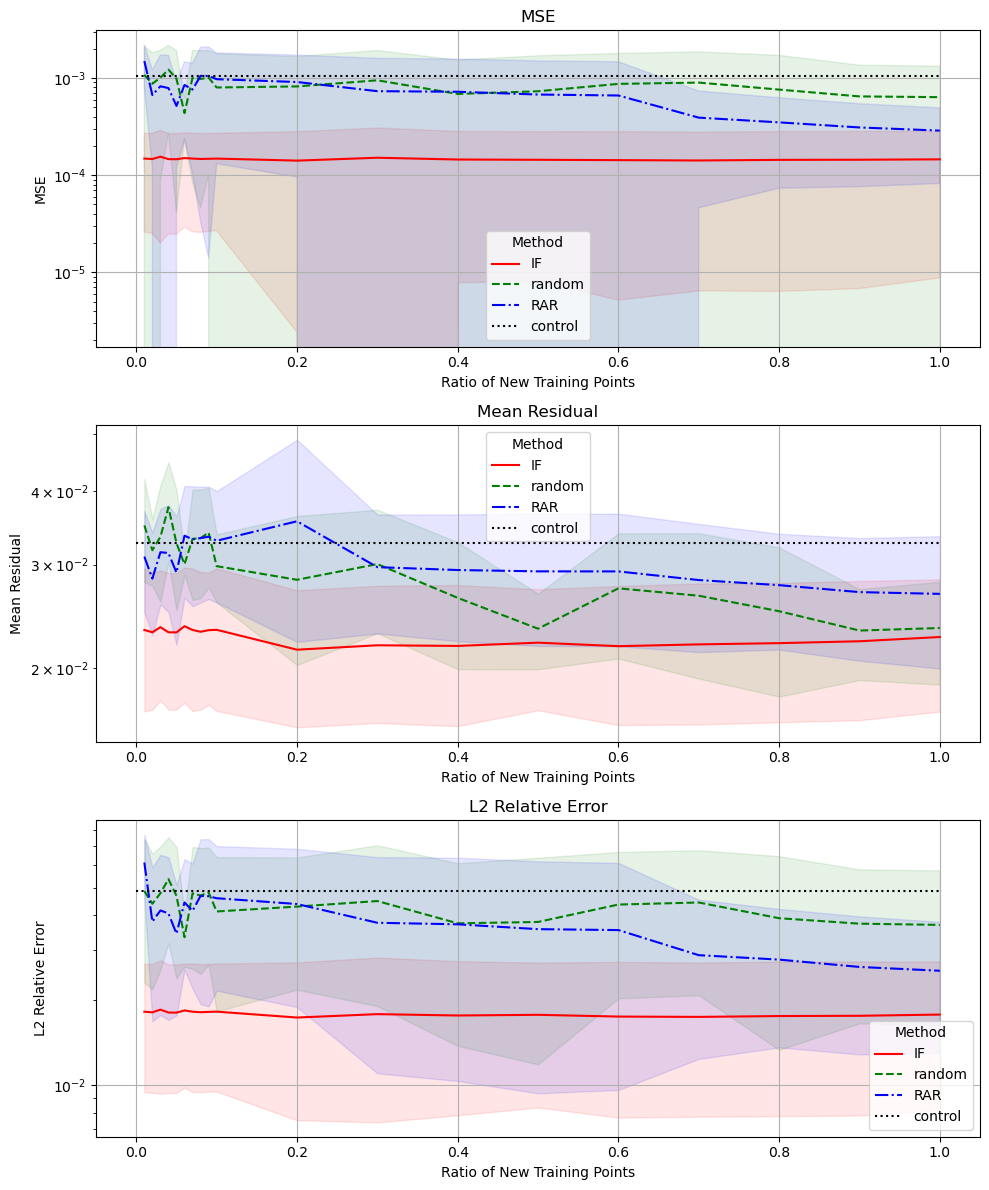

n_iter: 10000, hard_constrained: False


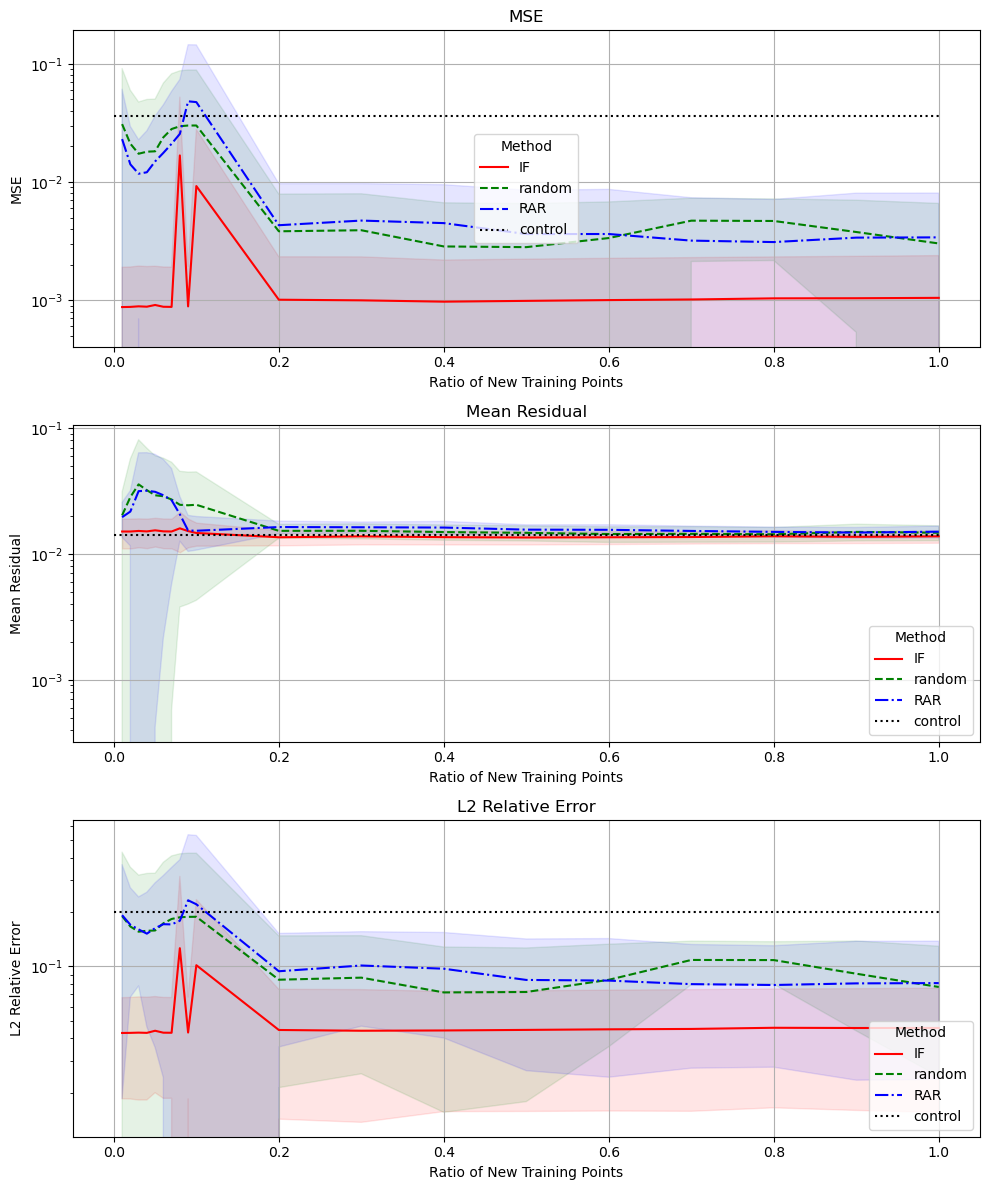

n_iter: 50000, hard_constrained: True


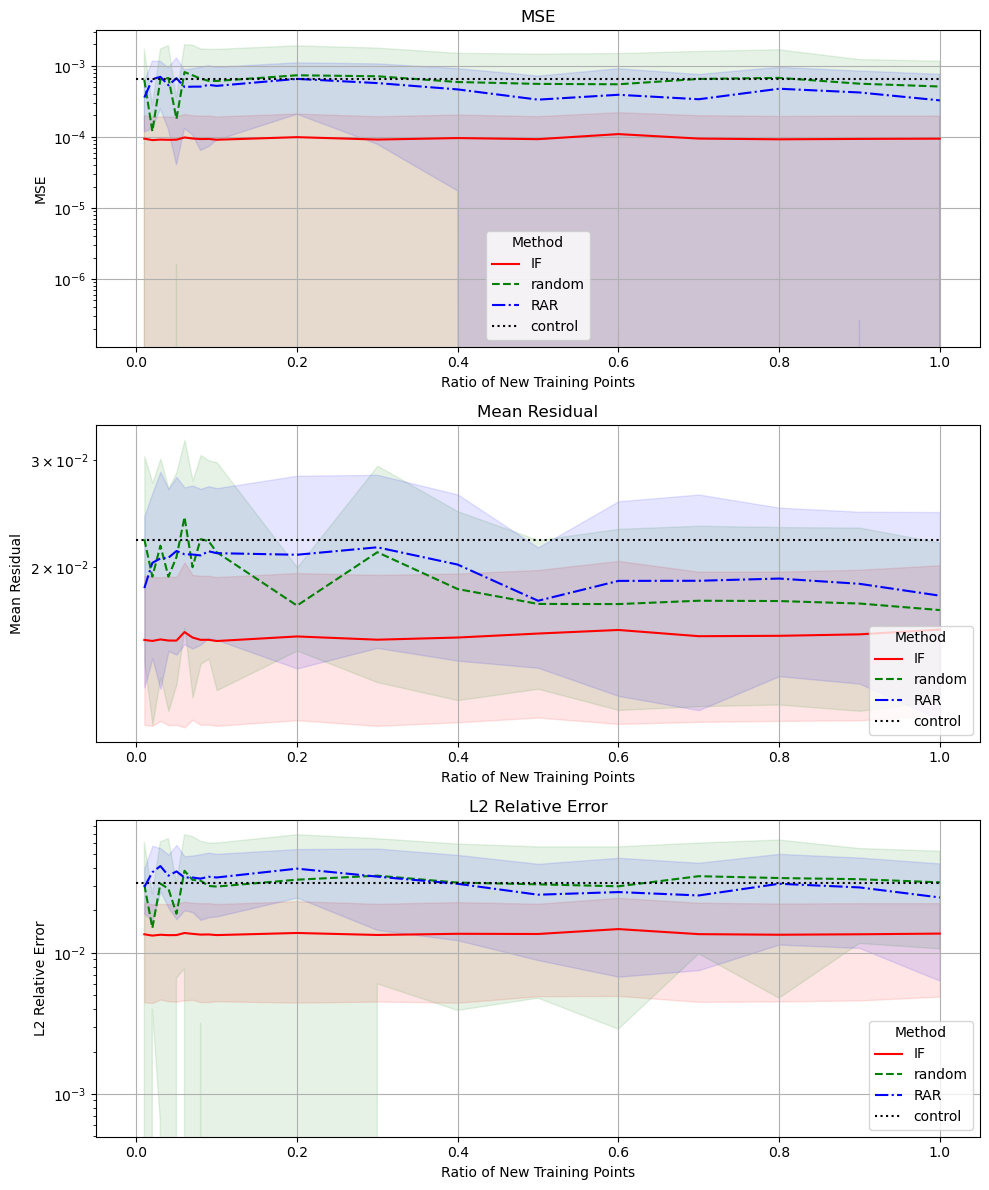

n_iter: 50000, hard_constrained: False


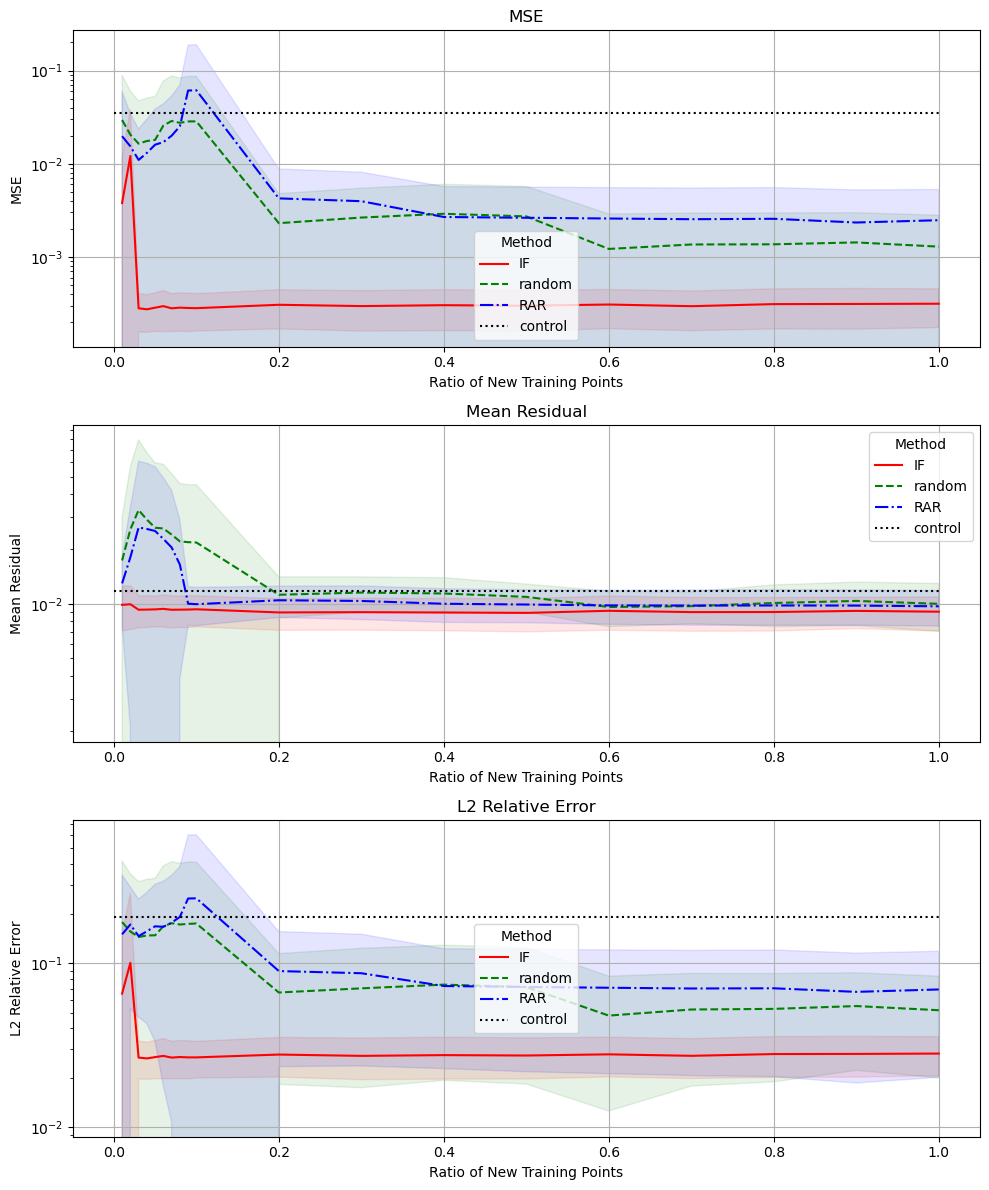

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming 'df' is your DataFrame already loaded
for n_iter in [10000, 50000]:
    for hard_constrained in [True, False]:
        print(f"n_iter: {n_iter}, hard_constrained: {hard_constrained}")
        # Filter the DataFrame
        sub_df = df.loc[
            (df['model_version'] == 'test') &
            (df['n_iterations'] == n_iter) &
            (df['hard_constrained'] == hard_constrained)
        ]

        # Group by 'method' and 'ratio' and calculate the mean and standard deviation
        # We'll include 'control' in our methods list
        methods = ['IF', 'random', 'RAR', 'control']
        grouped = sub_df.groupby(['method', 'ratio'])
        mean_df = grouped[['mse', 'l2_relative_error', 'mean_residual']].mean().reset_index()
        std_df = grouped[['mse', 'l2_relative_error', 'mean_residual']].std().reset_index()

        # Define your methods, colors, and styles
        method_colors = {'IF': 'r', 'random': 'g', 'RAR': 'b', 'control': 'k'}
        method_styles = {'IF': '-', 'random': '--', 'RAR': '-.', 'control': ':'}

        metrics = ['mse', 'mean_residual', 'l2_relative_error']
        metric_labels = {
            'mse': 'MSE',
            'mean_residual': 'Mean Residual',
            'l2_relative_error': 'L2 Relative Error'
        }

        # Create custom legend elements for methods
        method_legend_elements = [
            Line2D([0], [0], color=method_colors[method], linestyle=method_styles[method], label=method)
            for method in methods
        ]

        fig, ax = plt.subplots(nrows=3, figsize=(10, 12))

        # Define the ratio range for plotting the control line
        ratio_min = sub_df['ratio'].min()
        ratio_max = sub_df['ratio'].max()
        ratio_range = np.linspace(ratio_min, ratio_max, 100)

        for e, metric in enumerate(metrics):
            for method in methods:
                if method != 'control':
                    method_mean = mean_df[mean_df['method'] == method]
                    method_std = std_df[std_df['method'] == method]

                    color = method_colors[method]
                    line_style = method_styles[method]

                    ax[e].plot(method_mean['ratio'], method_mean[metric], color=color, linestyle=line_style)
                    ax[e].fill_between(
                        method_mean['ratio'],
                        method_mean[metric] - method_std[metric],
                        method_mean[metric] + method_std[metric],
                        color=color, alpha=0.1
                    )
                else:
                    # Handle the 'control' method
                    control_df = sub_df[sub_df['method'] == 'control']
                    if not control_df.empty:
                        # Calculate the mean and std for the 'control' measurement
                        mean_value = control_df[metric].mean()
                        std_value = control_df[metric].std()

                        color = method_colors[method]
                        line_style = method_styles[method]

                        # Plot the horizontal line across the ratio range
                        ax[e].plot(ratio_range, [mean_value]*len(ratio_range), color=color, linestyle=line_style)
                        # Add the fill_between for standard deviation
                        # ax[e].fill_between(
                        #     ratio_range,
                        #     [mean_value - std_value]*len(ratio_range),
                        #     [mean_value + std_value]*len(ratio_range),
                        #     color=color, alpha=0.05
                        # )

            ax[e].set_title(metric_labels[metric])
            ax[e].set_xlabel('Ratio of New Training Points')
            ax[e].set_ylabel(metric_labels[metric])
            ax[e].set_yscale('log')
            ax[e].grid()
            # Add custom legend
            ax[e].legend(handles=method_legend_elements, title='Method')

        plt.tight_layout()
        plt.show()